In [342]:
Path(os.getcwd()).parent.parent.absolute() / 'preprocessing.py'

WindowsPath('c:/Users/darth/Documents/Workspace/jpx_stock_challenge/preprocessing.py')

In [191]:
from typing import Optional, List
from pathlib import Path
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, linprog
import statsmodels.api as sm

from sklearn.mixture import GaussianMixture
from hmmlearn import hmm

#necessary to import preprocessing module
sys.path.append(str(Path(os.getcwd()).parent.parent.absolute()))

import preprocessing as pp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_csv('./../../jpx/train_files/stock_prices.csv')
fin_df = pd.read_csv('./../../jpx/train_files/financials.csv')
trades_df = pd.read_csv('./../../jpx/train_files/trades.csv')
options_df = pd.read_csv('./../../jpx/train_files/options.csv')
secondary_stock_df = pd.read_csv('./../../jpx/train_files/secondary_stock_prices.csv')

c:\Users\darth\Anaconda3\envs\aws\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


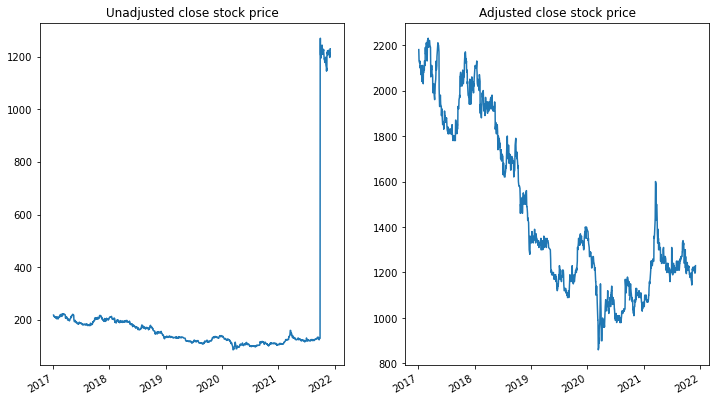

In [153]:
fig, axs = plt.subplots(1,2)
pp.get_stock_data(8713, stock_price_dataframe=df).Close.plot(ax=axs[0], title='Unadjusted close stock price')
pp.get_adjusted_stock_data(8713, stock_price_dataframe=df).Close.plot(ax=axs[1], title='Adjusted close stock price')
fig.set_size_inches(12,7)

In [166]:
security_codes = df.SecuritiesCode.sort_values().unique().tolist()
adjusted_stock_data = list()
for security_code in security_codes:
    adjusted_stock_data.append(
        pp.get_adjusted_stock_data(
            security_code=security_code, stock_price_dataframe=df
        )
    )

In [186]:
gmm = GaussianMixture(n_components=2, covariance_type='spherical')
gmm.fit(adjusted_stock_data[security_codes[5]].Close.pct_change().to_frame().dropna())

GaussianMixture(covariance_type='spherical', n_components=2)

In [190]:
gmm.means_
gmm.covariances_

array([0.00011347, 0.00076055])

In [208]:
gmm.weights_

array([0.67965246, 0.32034754])

In [213]:
x = np.linspace(-0.1,0.1,200)
y1 = gmm.weights_[0] * 1/(np.sqrt(2 * np.pi * gmm.covariances_[0])) * np.exp(-np.square(x - gmm.means_[0])/(2 * gmm.covariances_[0]))
y2 = gmm.weights_[1] * 1/(np.sqrt(2 * np.pi * gmm.covariances_[1])) * np.exp(-np.square(x - gmm.means_[1])/(2 * gmm.covariances_[1]))
z = y1 + y2

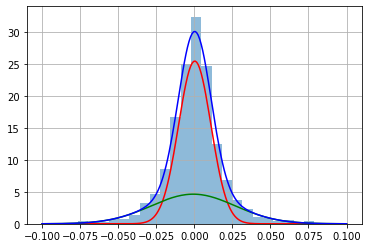

In [216]:
# adjusted_stock_data[security_codes[5]].Close.pct_change()[:500].plot()
adjusted_stock_data[security_codes[5]].Close.pct_change().hist(bins=25, density=True, alpha=0.5)
plt.plot(x, y1, color='red')
plt.plot(x, y2, color='green')
plt.plot(x, z, color='blue')

In [ ]:
date_index = pp.get_date_index(stock_price_dataframe=df)


In [230]:
hmm_model = hmm.GaussianHMM(n_components=2, covariance_type='diag')

<AxesSubplot:>

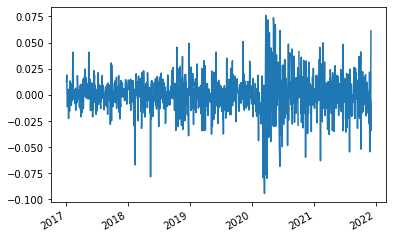

In [229]:
np.log(adjusted_stock_data[security_codes[5]].Close).diff().plot()

In [231]:
hmm_model.fit(np.log(adjusted_stock_data[security_codes[5]].Close).diff().to_frame().dropna())
Z = hmm_model.predict(np.log(adjusted_stock_data[security_codes[5]].Close).diff().to_frame().dropna())

GaussianHMM(n_components=2)

<AxesSubplot:>

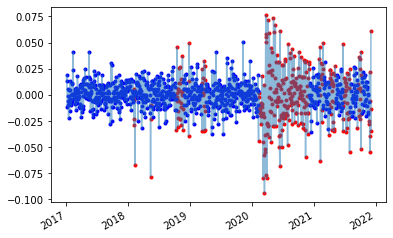

In [317]:
ind = np.log(adjusted_stock_data[security_codes[5]].Close).diff().dropna().index
Z = pd.Series(data=Z, index=ind)
tmp = np.log(adjusted_stock_data[security_codes[5]].Close).diff().dropna()
tmp[Z[Z>0].index].plot(style='.', color='red')
tmp[Z[Z<1].index].plot(style='.', color='blue')
tmp.plot(alpha=0.5)


In [314]:
hmm_model.transmat_ = np.array(
      [[0.99, 0.01],
       [0.05, 0.95]])

In [315]:
Z = hmm_model.predict(np.log(adjusted_stock_data[security_codes[5]].Close).diff().to_frame().dropna())

In [319]:
Z.value_counts(normalize=True)

0    0.710592
1    0.289408
dtype: float64

In [336]:
close_df = adjusted_stock_data[0][["Close"]].merge(
    adjusted_stock_data[1][["Close"]],
    left_index=True,
    right_index=True,
    suffixes=[f"_{security_codes[0]}",f"_{security_codes[1]}"]
)


In [337]:
for i, code in enumerate(security_codes):
    close_df = close_df.merge(
        adjusted_stock_data[i][["Close"]],
        left_index=True,
        right_index=True,
        suffixes=["",f"_{code}"]
    )

In [388]:
mean_returns = close_df.pct_change().iloc[:, 10:20].mean()
cov_matrix = close_df.pct_change().iloc[:, 10:20].cov()

In [403]:
def random_weights(size):
    coefs = np.random.random(size)
    return (np.exp(coefs)/np.exp(coefs).sum())

def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [367]:
w = random_weights(10)

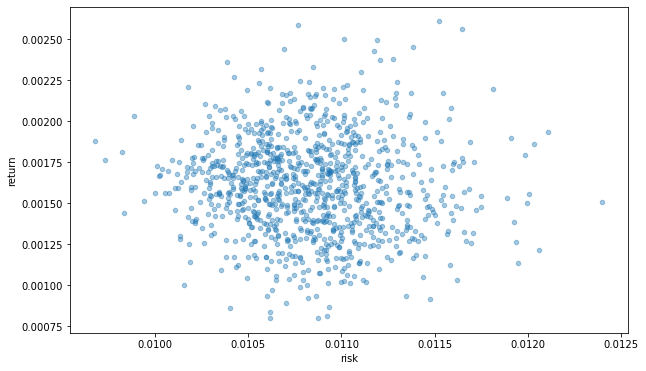

In [410]:
portifolios = []

i = 40
x = 10

mean_returns = close_df.pct_change().iloc[:100, i:i+x].mean()
cov_matrix = close_df.pct_change().iloc[:100, i:i+x].cov()

for i in range(1000):
    w = rand_weights(x)
    portifolio_return = w.dot(mean_returns)
    portifolio_risk = np.sqrt(w.T.dot(cov_matrix).dot(w))
    portifolios.append([portifolio_return, portifolio_risk])

ax = pd.DataFrame(portifolios, columns=['return','risk']).plot.scatter(x='risk', y='return', alpha=0.4, figsize=(10,6))


In [402]:
close_df.pct_change().dropna().iloc[:, :10].corr()

,Close_1301,Close_1332,Close,Close_1332,Close_1333,Close_1375,Close_1376,Close_1377,Close_1379,Close_1381
Close_1301,1.000000,0.325076,1.000000,0.325076,0.476960,0.299965,0.259126,0.349057,0.386271,-0.062553
Close_1332,0.325076,1.000000,0.325076,1.000000,0.630840,0.245763,0.239218,0.374514,0.303982,0.057227
Close,1.000000,0.325076,1.000000,0.325076,0.476960,0.299965,0.259126,0.349057,0.386271,-0.062553
Close_1332,0.325076,1.000000,0.325076,1.000000,0.630840,0.245763,0.239218,0.374514,0.303982,0.057227
Close_1333,0.476960,0.630840,0.476960,0.630840,1.000000,0.370045,0.309450,0.440654,0.414143,0.066819
Close_1375,0.299965,0.245763,0.299965,0.245763,0.370045,1.000000,0.283564,0.269529,0.228332,0.115245
Close_1376,0.259126,0.239218,0.259126,0.239218,0.309450,0.283564,1.000000,0.317777,0.300617,0.105366
Close_1377,0.349057,0.374514,0.349057,0.374514,0.440654,0.269529,0.317777,1.000000,0.412487,0.145581
Close_1379,0.386271,0.303982,0.386271,0.303982,0.414143,0.228332,0.300617,0.412487,1.000000,0.084190
Close_1381,-0.062553,0.057227,-0.062553,0.057227,0.066819,0.115245,0.105366,0.145581,0.084190,1.000000


In [412]:
close_df.pct_change()

,Close_1301,Close_1332,Close,Close_1332,Close_1333,Close_1375,Close_1376,Close_1377,Close_1379,Close_1381,Close_1407,Close_1413,Close_1414,Close_1417,Close_1419,Close_1429,Close_1431,Close_1435,Close_1515,Close_1518,Close_1605,Close_1662,Close_1663,Close_1712,Close_1716,Close_1719,Close_1720,Close_1721,Close_1723,Close_1726,Close_1762,Close_1766,Close_1775,Close_1780,Close_1787,Close_1793,Close_1799,Close_1801,Close_1802,Close_1803,...,Close_9843,Close_9850,Close_9856,Close_9861,Close_9869,Close_9873,Close_9880,Close_9882,Close_9887,Close_9889,Close_9896,Close_9900,Close_9902,Close_9903,Close_9906,Close_9919,Close_9928,Close_9932,Close_9934,Close_9936,Close_9945,Close_9946,Close_9948,Close_9955,Close_9956,Close_9960,Close_9962,Close_9974,Close_9977,Close_9979,Close_9982,Close_9983,Close_9984,Close_9987,Close_9989,Close_9990,Close_9991,Close_9993,Close_9994,Close_9997
2020-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-24,0.001373,0.002387,0.001373,0.002387,0.006005,-0.017123,-0.003783,0.008511,-0.000948,0.012195,0.034637,0.014419,-0.013780,0.001193,0.000000,-0.010606,0.002475,0.024540,0.073427,-0.005789,0.049451,0.029173,-0.013699,-0.001460,-0.012436,0.005698,0.002008,-0.003221,-0.003942,0.012579,0.000000,0.003736,0.006813,0.006383,NaN,0.001953,0.000000,0.004348,0.010453,0.010929,...,-0.000227,0.000000,0.007290,0.003714,0.021994,-0.011427,0.009128,0.019327,0.001504,0.019095,0.025346,-0.006520,0.020036,0.019934,0.000000,0.013878,0.011214,-0.052506,0.010265,0.001724,-0.003458,0.001432,0.016762,0.011875,0.009192,0.022605,0.000000,0.014469,0.006128,0.016615,0.002600,0.018975,-0.016471,0.004000,0.008464,0.009634,0.010460,-0.001674,0.001856,0.045918
2020-12-25,-0.000343,0.007143,-0.000343,0.007143,0.005051,-0.003484,-0.009494,0.011252,0.002373,-0.003012,0.047516,0.008712,0.005988,0.010721,0.000692,0.003063,-0.013333,0.023952,0.027687,0.014556,0.008726,0.004724,0.009028,0.014620,-0.011111,0.004249,-0.002004,0.003231,-0.009235,0.017081,0.001480,0.004963,-0.004350,-0.001057,0.000000,-0.023392,-0.003846,0.008658,0.012644,0.006757,...,-0.007278,-0.002014,0.009650,0.011099,0.001435,0.004904,0.019095,0.024465,0.019520,0.010409,0.006742,-0.004102,0.013968,-0.009772,0.003378,-0.000805,-0.000964,0.031486,0.002345,0.003442,0.006362,0.003574,0.015618,-0.009265,0.011385,0.010877,0.002976,0.001585,0.000717,0.005107,-0.005705,0.004655,-0.031478,-0.006640,-0.003597,0.001908,0.001035,-0.019005,0.000463,0.039024
2020-12-28,0.011660,-0.007092,0.011660,-0.007092,0.007766,-0.015152,-0.008307,0.005563,-0.008049,0.015106,-0.016495,0.011364,-0.001984,0.009428,-0.006220,-0.010687,-0.001502,-0.035088,-0.023772,-0.002869,-0.008651,-0.013584,0.000000,-0.005764,0.008989,-0.002821,-0.010040,-0.008052,0.001332,-0.022901,0.005911,0.008642,0.017961,-0.015873,-0.014941,0.015968,0.011583,0.008584,0.000000,-0.006711,...,-0.013058,-0.018163,-0.041816,-0.019864,-0.001433,-0.006971,-0.003945,-0.014925,-0.005891,-0.015797,-0.010045,-0.019769,-0.015928,0.008224,-0.006734,-0.004029,-0.005309,-0.000407,-0.001949,-0.012007,-0.002874,-0.005698,-0.008116,-0.005611,-0.004128,-0.005207,0.004451,-0.007911,0.002506,-0.020325,0.009390,0.006719,0.001820,-0.013369,0.002407,-0.005714,0.001034,-0.005128,0.012500,0.006573
2020-12-29,0.003729,0.019048,0.003729,0.019048,0.013599,0.008876,0.028351,0.002766,0.005728,0.007440,0.007338,-0.018427,0.005964,0.019264,0.009040,0.003086,0.006015,0.036364,-0.012987,0.041727,-0.019197,0.008475,0.025465,0.008696,0.107647,0.024045,0.008114,0.037338,0.013298,0.003125,0.014202,0.014688,0.027659,0.010753,0.000000,0.021611,-0.002181,0.018440,0.020431,0.024324,...,0.013695,0.006166,0.011222,0.026667,0.028694,0.005616,0.019802,0.015758,0.013333,0.016748,0.003382,0.032773,0.